In [2]:
from datamodules.ucg2cg import UCG2CGDataModule
from modules.diffusion_model import LitUCG2CGNoiseNet

In [3]:
datamodule = UCG2CGDataModule(
        cg_files       = ["sample-data/cg/pfpatch_000000000138.npz", "sample-data/cg/pfpatch_000000000214.npz", "sample-data/cg/pfpatch_000000000272.npz"],
        ucg_files      = ["sample-data/ucg/pfpatch_000000000138_ucg.npz", "sample-data/ucg/pfpatch_000000000214_ucg.npz", "sample-data/ucg/pfpatch_000000000272_ucg.npz"],
        ucg_index_file = "sample-data/cg/all_indices_per_cluster.npz",
        batch_size     = 3,
        num_workers    = 1,
        train_size     = 0.5,
    )

In [4]:
datamodule.setup()
loader = datamodule.val_dataloader()
batch = next(iter(loader))
ucg_pos = batch['ucg_pos']
cg_pos = batch["cg_pos"]

In [5]:
ckpt_path = 'lightning_logs/version_8/checkpoints/epoch=1800-step=585325.ckpt'
# ckpt_path = "lit_logs/dimers-C/version_0/checkpoints/epoch=16-step=100.ckpt"
noise_net = LitUCG2CGNoiseNet.load_from_checkpoint(ckpt_path, ucg_index_file="sample-data/cg/all_indices_per_cluster.npz")



In [6]:
import torch

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

noise_net = noise_net.to(device)
ucg_pos = ucg_pos.to(device)

pred_cg_pos = noise_net.generate(ucg_pos, num_steps=10)

In [7]:
import numpy as np
import torch
from utils.datautils import DataUtils
from utils.viz import plot_rmsds

def generate_rmsd_plot(num_steps):
    # Collect RMSDs
    all_rmsds = []

    datamodule.setup()
    val_loader = datamodule.val_dataloader()

    noise_net.eval()
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    for batch in val_loader:
        ucg_pos = batch["ucg_pos"].to(device)  # shape: (B, N, 3)
        cg_pos = batch["cg_disp"].numpy()    # shape: (B, N, 3)

        with torch.no_grad():
            pred_cg_pos = noise_net.generate(ucg_pos, num_steps)
            
        pred_cg_pos = pred_cg_pos[:,-1,:,:]
        pred_cg_pos = pred_cg_pos.cpu().numpy()

        batch_rmsds = DataUtils.rmsd(pred_cg_pos, cg_pos)  # shape: (B,)
        all_rmsds.extend(batch_rmsds.tolist())

    all_rmsds = np.array(all_rmsds)

    # Plotting
    plot_rmsds(all_rmsds, title="Validation RMSD Distribution", filename="val_rmsd.png")

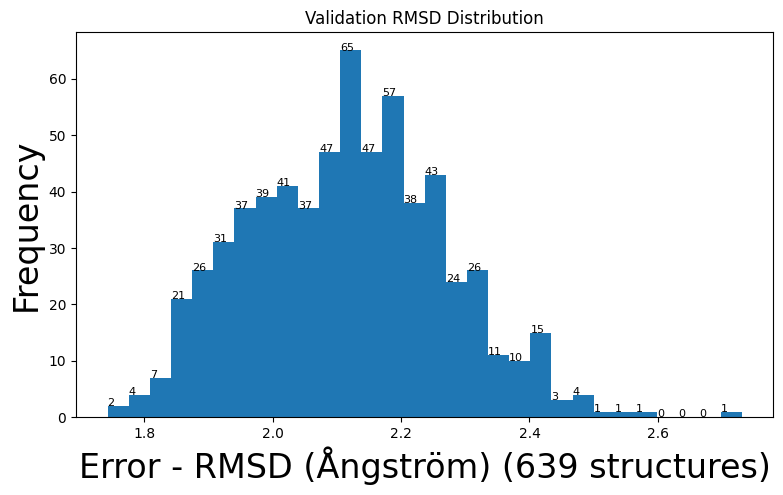

In [8]:
generate_rmsd_plot(num_steps=10)

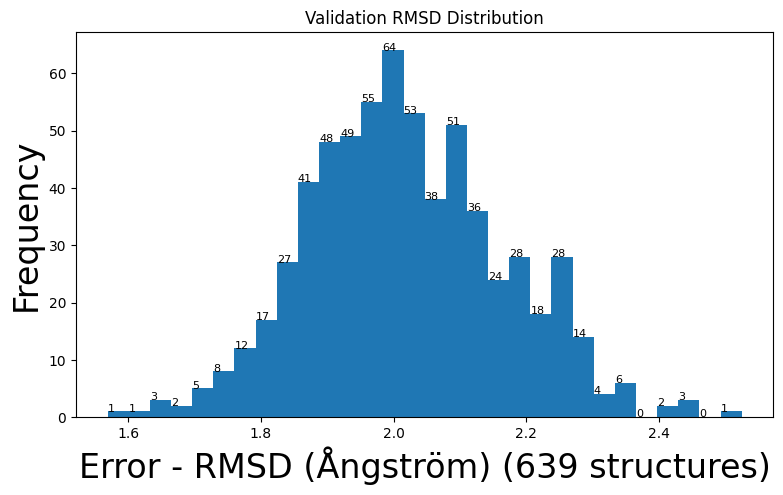

In [9]:
generate_rmsd_plot(num_steps=50)

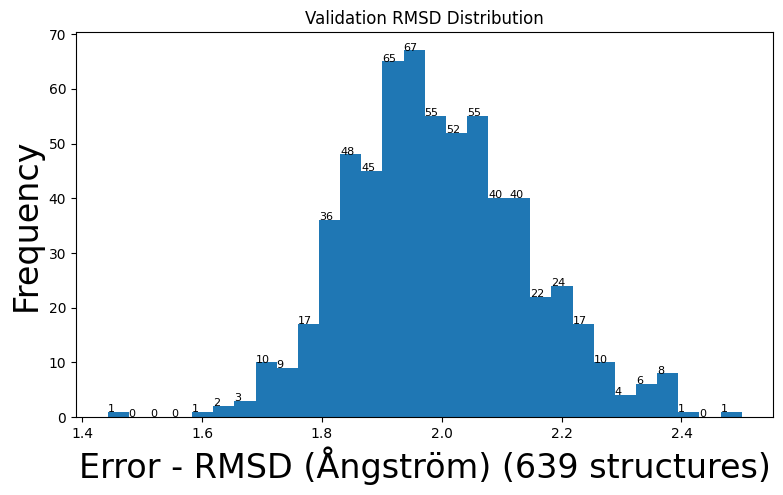

In [10]:
generate_rmsd_plot(num_steps=500)

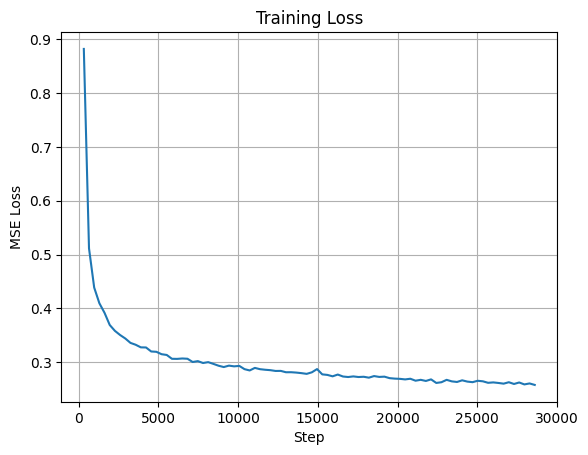

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("/Users/jonathan/Downloads/version_7_train.csv")
plt.plot(df['Step'], df['Value'])
plt.xlabel("Step")
plt.ylabel("MSE Loss")
plt.title("Training Loss")
plt.grid(True)
# plt.savefig("loss_plot.png", dpi=300)  # Saves a high-quality image
plt.show()

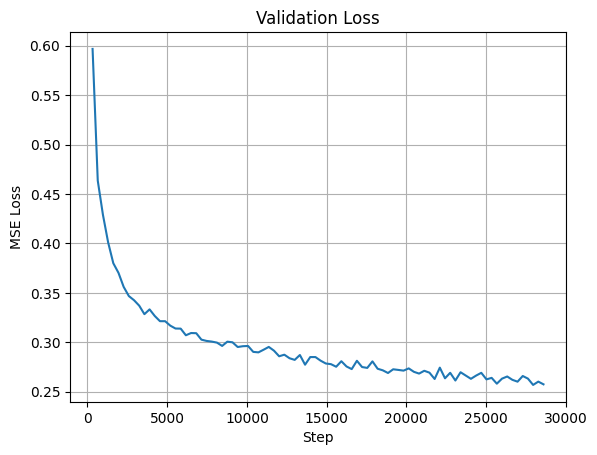

In [16]:
df = pd.read_csv("/Users/jonathan/Downloads/version_7_validation.csv")
plt.plot(df['Step'], df['Value'])
plt.xlabel("Step")
plt.ylabel("MSE Loss")
plt.title("Validation Loss")
plt.grid(True)
# plt.savefig("loss_plot.png", dpi=300)  # Saves a high-quality image
plt.show()